In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import seaborn as sns
import plotly.express as px

## Parsing, loading, and more

In [2]:
def parse_confusion_matrix(cm_str):
    """
    Parses strings like:
      '[[0 7]\n [0 8]]'
      '[[7 0]\n [8 0]]'
    Returns tn, fp, fn, tp as ints, or NaNs if missing.
    """
    if pd.isna(cm_str):
        return np.nan, np.nan, np.nan, np.nan

    s = str(cm_str).strip()

    # extract 4 integers in row-major order
    nums = re.findall(r"-?\d+", s)
    if len(nums) < 4:
        return np.nan, np.nan, np.nan, np.nan

    tn, fp, fn, tp = map(int, nums[:4])
    return tn, fp, fn, tp

def safe_div(a, b):
    return np.where(b == 0, np.nan, a / b)

In [3]:
def add_derived_columns(df):
    # Parse confusion matrix
    tn_fp_fn_tp = df["confusion matrix"].apply(parse_confusion_matrix)
    df[["tn", "fp", "fn", "tp"]] = pd.DataFrame(tn_fp_fn_tp.tolist(), index=df.index)

    # test n (prefer your stored test size; otherwise derive from cm)
    df["n_test_cm"] = df[["tn", "fp", "fn", "tp"]].sum(axis=1)
    df["n_test"] = df["test size"].where(~df["test size"].isna(), df["n_test_cm"])

    # getting rate metrics!
    df["tpr_recall"] = safe_div(df["tp"], (df["tp"] + df["fn"]))         # same as recall
    df["tnr_specificity"] = safe_div(df["tn"], (df["tn"] + df["fp"]))
    df["fpr"] = safe_div(df["fp"], (df["fp"] + df["tn"]))
    df["pred_pos_rate"] = safe_div((df["tp"] + df["fp"]), df["n_test"])
    df["prevalence"] = safe_div((df["tp"] + df["fn"]), df["n_test"])

    df["balanced_accuracy"] = 0.5 * (df["tpr_recall"] + df["tnr_specificity"])

    # Degenerate predictor flags
    df["degenerate_all_pos"] = (df["tn"] == 0) & (df["fn"] == 0) & df["n_test"].notna()
    df["degenerate_all_neg"] = (df["tp"] == 0) & (df["fp"] == 0) & df["n_test"].notna()

    # clean model name
    df["model used"] = df["model used"].astype(str).str.strip().str.lower()

    # Build a single privacy label (handy for plots)
    # (Keep it simple; you can customize later.)
    def _privacy_id(row):
        k = row.get("k-level", "")
        l = row.get("l-diversity level", "")
        t = row.get("t-closeness level", "")
        sup = row.get("suppression level", "")
        return f"k={k}|l={l}|t={t}|sup={sup}"

    df["privacy_id"] = df.apply(_privacy_id, axis=1)

    return df

In [4]:
# load
# -----------------------------
k_df = pd.read_csv("results_k_with_features.csv")
l_df = pd.read_csv("results_l_with_features.csv")
t_df = pd.read_csv("results_t_with_features.csv")

# getting rid of blank cells
k_df = k_df.replace(r"^\s*$", np.nan, regex=True)
l_df = l_df.replace(r"^\s*$", np.nan, regex=True)
t_df = t_df.replace(r"^\s*$", np.nan, regex=True)

# grabbing the true pos/neg and false pos/neg rates
k_df = add_derived_columns(k_df)
l_df = add_derived_columns(l_df)
t_df = add_derived_columns(t_df)

## k anon

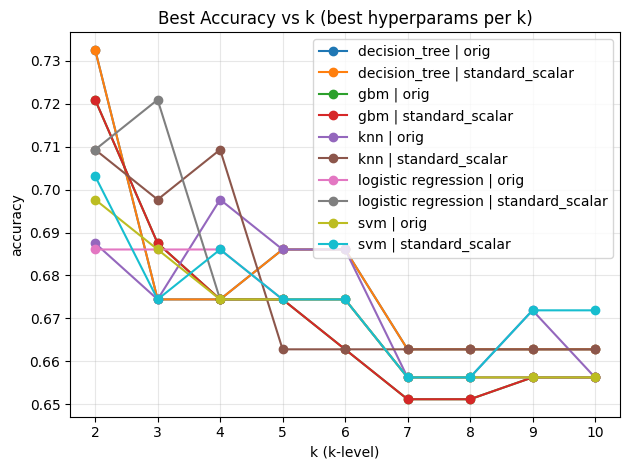

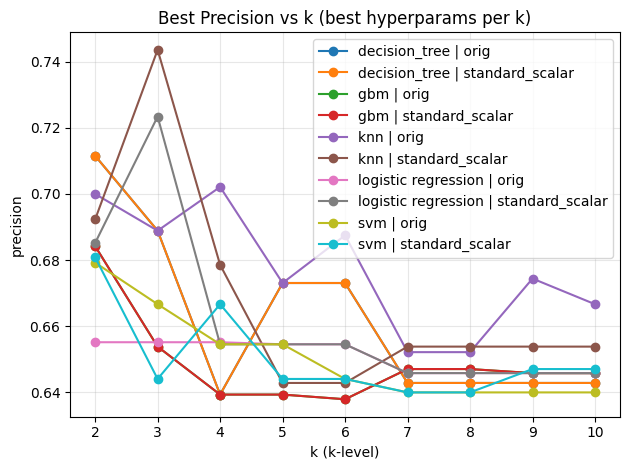

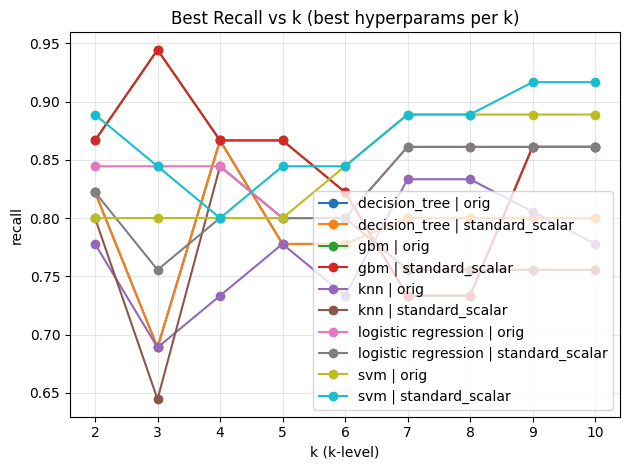

In [5]:
# make sure k is numeric (your code currently saves it as string)
k_df["k-level"] = pd.to_numeric(k_df["k-level"], errors="coerce")

# keep only k-anonym results (optional, but likely what you want)
# df = df[df["anonymization type"].astype(str).str.startswith("k")]

# Define "hyperparameter combo"... include *all* hyperparam columns so combos are unique per model.
# -----------------------------
k_hyperparam_cols = [
    "logistic_reg_c", "lr_ratios",
    "nn_layers", "nn_neurons", "nn_batch_size", "nn_epochs",
    "dt_max_depth", "dt_min_samples_split",
    "svm_c_val", "svm_kernel",
    "knn_n_neighbor", "knn_metric",
    "gbm_learning_rate", "gbm_n_estimator",
]

# Only keep columns that exist
k_hyperparam_cols = [c for c in k_hyperparam_cols if c in k_df.columns]

# Base grouping keys
k_base_cols = ["k-level", "model used", "scalar_status"]

# This defines a "hyperparam combo"
combo_cols = k_base_cols + k_hyperparam_cols

# Best row per hyperparam combo (dedupe)
#    If you have multiple rows with same combo (e.g., repeats), keep the max-accuracy row.
#    Also keeps precision/recall from that winning row.
# -----------------------------
k_df = k_df.dropna(subset=["k-level", "accuracy"])  # basic safety

best_per_combo = k_df.loc[k_df.groupby(combo_cols, dropna=False)["accuracy"].idxmax()].copy()

# Best model per k (per model + scaler)
#    This picks the single best hyperparam combo at each k for each model/scaler.
# -----------------------------
best_per_k = best_per_combo.loc[
    best_per_combo.groupby(k_base_cols)["accuracy"].idxmax()
].copy()

# Sort for nicer plots
best_per_k = best_per_k.sort_values(["model used", "scalar_status", "k-level"])

# plot helper
# -----------------------------
def plot_metric(metric: str, title: str):
    plt.figure()
    for (model, scaler), g in best_per_k.groupby(["model used", "scalar_status"], dropna=False):
        g = g.sort_values("k-level")
        label = f"{model} | {scaler}"
        plt.plot(g["k-level"], g[metric], marker="o", label=label)

    plt.xlabel("k (k-level)")
    plt.ylabel(metric)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_metric("accuracy",  "Best Accuracy vs k (best hyperparams per k)")
plot_metric("precision", "Best Precision vs k (best hyperparams per k)")
plot_metric("recall",    "Best Recall vs k (best hyperparams per k)")


## l-diversity

In [11]:
import plotly.graph_objects as go


In [ ]:
# load
# -----------------------------
l_df = pd.read_csv("results_l_with_features.csv")

# getting rid of blank cells
l_df = l_df.replace(r"^\s*$", np.nan, regex=True)

# grabbing the true pos/neg and false pos/neg rates
l_df = add_derived_columns(l_df)

# make sure numeric
l_df["k-level"] = pd.to_numeric(l_df["k-level"], errors="coerce")
l_df["l-diversity level"] = pd.to_numeric(l_df["l-diversity level"], errors="coerce")

# hyperparam combo columns (only keep existing)
l_hyperparam_cols = [
    "logistic_reg_c", "lr_ratios",
    "nn_layers", "nn_neurons", "nn_batch_size", "nn_epochs",
    "dt_max_depth", "dt_min_samples_split",
    "svm_c_val", "svm_kernel",
    "knn_n_neighbor", "knn_weights",
    "gbm_learning_rate", "gbm_n_estimator",
]
l_hyperparam_cols = [c for c in l_hyperparam_cols if c in l_df.columns]

# base grouping keys now include BOTH k and l
base_cols = ["k-level", "l-diversity level", "model used", "scalar_status"]
combo_cols = base_cols + l_hyperparam_cols


# plot helper
# -----------------------------
def l_plot_metric(l_df, metric: str, title: str):

    l_df = l_df.dropna(subset=["k-level", "l-diversity level", "accuracy"])
    # best row per hyperparam combo
    best_per_combo = l_df.loc[l_df.groupby(combo_cols, dropna=False)["accuracy"].idxmax()].copy()

    # best model per (k,l) for each model/scaler
    best_per_kl = best_per_combo.loc[
        best_per_combo.groupby(base_cols)["accuracy"].idxmax()
    ].copy()
    
    label_df = best_per_kl.sort_values("accuracy", ascending=False).groupby("model used").head(1)

    # fig = px.scatter_3d(
    #     best_per_kl,
    #     x="k-level",
    #     y="l-diversity level",
    #     z=metric,
    #     color="model used",
    #     symbol="scalar_status",
    #     opacity=0.65,
    #     title=title
    # )
    # fig.add_scatter3d(
    #     x=label_df["k-level"],
    #     y=label_df["l-diversity level"],
    #     z=label_df[metric],
    #     mode="text",
    #     text=label_df["model used"],
    #     textposition="top center",
    #     showlegend=False
    # )

    # fig = go.Figure()
    # for (model, lval), g in best_per_kl.groupby(["model used", "l-diversity level"]):
    #     g = g.sort_values("k-level")
    #     fig.add_trace(go.Scatter3d(
    #         x=g["k-level"], y=g["l-diversity level"], z=g[metric],
    #         mode="lines+markers",
    #         name=f"{model} | l={lval}"
    #     ))
    # fig.update_layout(title=title)

    # k_vals = sorted(best_per_kl["k-level"].dropna().unique())
    # l_vals = sorted(best_per_kl["l-diversity level"].dropna().unique())
    # zmin = best_per_kl["accuracy"].min()
    # zmax = best_per_kl["accuracy"].max()
    # fig = px.scatter_3d(
    #     best_per_kl,
    #     x="k-level", y="l-diversity level", z="accuracy",
    #     color="model used", symbol="scalar_status", opacity=0.75,
    #     title=title
    # )
    # # planes for each k (vertical)
    # for k in k_vals:
    #     fig.add_trace(go.Surface(
    #         x=[[k, k], [k, k]],
    #         y=[[min(l_vals), max(l_vals)], [min(l_vals), max(l_vals)]],
    #         z=[[zmin, zmin], [zmax, zmax]],
    #         showscale=False,
    #         opacity=0.08,
    #         colorscale=[[0, "gray"], [1, "gray"]],
    #         name=f"k={k}",
    #         hoverinfo="skip"
    #     ))
    # # planes for each l (vertical)
    # for l in l_vals:
    #     fig.add_trace(go.Surface(
    #         x=[[min(k_vals), max(k_vals)], [min(k_vals), max(k_vals)]],
    #         y=[[l, l], [l, l]],
    #         z=[[zmin, zmax], [zmin, zmax]],
    #         showscale=False,
    #         opacity=0.08,
    #         colorscale=[[0, "lightgray"], [1, "lightgray"]],
    #         name=f"l={l}",
    #         hoverinfo="skip"
    #     ))

    fig = px.scatter_3d(
        best_per_kl,
        x="k-level",
        y="l-diversity level",
        z="accuracy",
        color="model used",
        symbol="scalar_status",
        opacity=0.75,
        title=title
    )

    # turn on grid + drop lines
    fig.update_layout(
        scene=dict(
            xaxis=dict(showgrid=True, gridcolor="lightgray"),
            yaxis=dict(showgrid=True, gridcolor="lightgray"),
            zaxis=dict(showgrid=True, gridcolor="lightgray"),
            bgcolor="white"
        )
    )

    # this adds vertical projection lines to the axis planes
    fig.update_traces(
        marker=dict(size=4),
        projection=dict(
            x=dict(show=True, opacity=0.2),
            y=dict(show=True, opacity=0.2),
            z=dict(show=True, opacity=0.2),
        )
    )


    fig.write_html(f"{title}.html")

l_plot_metric(l_df, "accuracy",  "Best Accuracy per (k, l) by Model")
l_plot_metric(l_df, "precision", "Best Precision per (k, l) by Model")
l_plot_metric(l_df, "recall",    "Best Recall per (k, l) by Model")



## t-closeness

In [22]:
# load
# -----------------------------
t_df = pd.read_csv("results_t_with_features.csv")

# getting rid of blank cells
t_df = t_df.replace(r"^\s*$", np.nan, regex=True)

# grabbing the true pos/neg and false pos/neg rates
t_df = add_derived_columns(t_df)

# make sure numeric
t_df["k-level"] = pd.to_numeric(t_df["k-level"], errors="coerce")
t_df["t-closeness level"] = pd.to_numeric(t_df["t-closeness level"], errors="coerce")

# hyperparam combo columns (only keep existing)
t_hyperparam_cols = [
    "logistic_reg_c", "lr_ratios",
    "nn_layers", "nn_neurons", "nn_batch_size", "nn_epochs",
    "dt_max_depth", "dt_min_samples_split",
    "svm_c_val", "svm_kernel",
    "knn_n_neighbor", "knn_weights",
    "gbm_learning_rate", "gbm_n_estimator",
]
t_hyperparam_cols = [c for c in t_hyperparam_cols if c in t_df.columns]

# base grouping keys now include BOTH k and l
base_cols = ["k-level", "t-closeness level", "model used", "scalar_status"]
combo_cols = base_cols + t_hyperparam_cols


# plot helper
# -----------------------------
def t_plot_metric(t_df, metric: str, title: str):

    t_df = t_df.dropna(subset=["k-level", "t-closeness level", "accuracy"])
    # best row per hyperparam combo
    best_per_combo = t_df.loc[t_df.groupby(combo_cols, dropna=False)["accuracy"].idxmax()].copy()

    # best model per (k,l) for each model/scaler
    best_per_kt = best_per_combo.loc[
        best_per_combo.groupby(base_cols)["accuracy"].idxmax()
    ].copy()
    
    label_df = best_per_kt.sort_values("accuracy", ascending=False).groupby("model used").head(1)

    colorscales = [
        "Viridis", "Cividis", "Plasma", "Magma", "Inferno",
        "Turbo", "Blues", "Greens", "Reds", "Oranges",
        "YlGnBu", "YlOrRd", "PuBuGn", "GnBu", "Aggrnyl"
    ]

    # fig = px.scatter_3d(
    #     best_per_kl,
    #     x="k-level",
    #     y="l-diversity level",
    #     z=metric,
    #     color="model used",
    #     symbol="scalar_status",
    #     opacity=0.65,
    #     title=title
    # )
    # fig.add_scatter3d(
    #     x=label_df["k-level"],
    #     y=label_df["l-diversity level"],
    #     z=label_df[metric],
    #     mode="text",
    #     text=label_df["model used"],
    #     textposition="top center",
    #     showlegend=False
    # )

    # fig = go.Figure()
    # for (model, lval), g in best_per_kl.groupby(["model used", "l-diversity level"]):
    #     g = g.sort_values("k-level")
    #     fig.add_trace(go.Scatter3d(
    #         x=g["k-level"], y=g["l-diversity level"], z=g[metric],
    #         mode="lines+markers",
    #         name=f"{model} | l={lval}"
    #     ))
    # fig.update_layout(title=title)

    # k_vals = sorted(best_per_kl["k-level"].dropna().unique())
    # l_vals = sorted(best_per_kl["l-diversity level"].dropna().unique())
    # zmin = best_per_kl["accuracy"].min()
    # zmax = best_per_kl["accuracy"].max()
    # fig = px.scatter_3d(
    #     best_per_kl,
    #     x="k-level", y="l-diversity level", z="accuracy",
    #     color="model used", symbol="scalar_status", opacity=0.75,
    #     title=title
    # )
    # # planes for each k (vertical)
    # for k in k_vals:
    #     fig.add_trace(go.Surface(
    #         x=[[k, k], [k, k]],
    #         y=[[min(l_vals), max(l_vals)], [min(l_vals), max(l_vals)]],
    #         z=[[zmin, zmin], [zmax, zmax]],
    #         showscale=False,
    #         opacity=0.08,
    #         colorscale=[[0, "gray"], [1, "gray"]],
    #         name=f"k={k}",
    #         hoverinfo="skip"
    #     ))
    # # planes for each l (vertical)
    # for l in l_vals:
    #     fig.add_trace(go.Surface(
    #         x=[[min(k_vals), max(k_vals)], [min(k_vals), max(k_vals)]],
    #         y=[[l, l], [l, l]],
    #         z=[[zmin, zmax], [zmin, zmax]],
    #         showscale=False,
    #         opacity=0.08,
    #         colorscale=[[0, "lightgray"], [1, "lightgray"]],
    #         name=f"l={l}",
    #         hoverinfo="skip"
    #     ))

    # fig = px.scatter_3d(
    #     best_per_kt,
    #     x="k-level",
    #     y="t-closeness level",
    #     z="accuracy",
    #     color="model used",
    #     symbol="scalar_status",
    #     opacity=0.75,
    #     title=title
    # )
    # # turn on grid + drop lines
    # fig.update_layout(
    #     scene=dict(
    #         xaxis=dict(showgrid=True, gridcolor="lightgray"),
    #         yaxis=dict(showgrid=True, gridcolor="lightgray"),
    #         zaxis=dict(showgrid=True, gridcolor="lightgray"),
    #         bgcolor="white"
    #     )
    # )
    # # this adds vertical projection lines to the axis planes
    # fig.update_traces(
    #     marker=dict(size=4),
    #     projection=dict(
    #         x=dict(show=True, opacity=0.2),
    #         y=dict(show=True, opacity=0.2),
    #         z=dict(show=True, opacity=0.2),
    #     )
    # )
    

    # just one model
    # for (model, scaler), g in best_per_kt.groupby(["model used", "scalar_status"]):
    #     pivot = g.pivot_table(
    #         index="t-closeness level",
    #         columns="k-level",
    #         values=metric
    #     )
    #     if pivot.isna().any().any():
    #         print(f"Skipping surface for {model} | {scaler}: missing grid points")
    #         continue
    #         # x, y, z
    #     x = pivot.columns.values
    #     y = pivot.index.values
    #     z = pivot.values
    #     # figure
    #     fig = go.Figure(data=[go.Surface(x=x, y=y, z=z, colorscale="Viridis")])
    #     fig.update_layout(
    #         title=f"{metric} surface: {model} | {scaler}",
    #         scene=dict(
    #             xaxis_title="k-level",
    #             yaxis_title="t-closeness level",
    #             zaxis_title=metric
    #         )
    #     )


    # for (model, scaler), g in best_per_kt.groupby(["model used", "scalar_status"]):
    #     pivot = g.pivot_table(
    #         index="t-closeness level",
    #         columns="k-level",
    #         values=metric
    #     )

    #     if pivot.isna().any().any():
    #         print(f"Skipping surface for {model} | {scaler}: missing grid points")
    #         continue

    #     x = pivot.columns.values
    #     y = pivot.index.values
    #     z = pivot.values

    #     fig = go.Figure(data=[go.Surface(x=x, y=y, z=z, colorscale="Viridis")])
    #     fig.update_layout(
    #         title=f"{metric} surface: {model} | {scaler}",
    #         scene=dict(
    #             xaxis_title="k-level",
    #             yaxis_title="t-closeness level",
    #             zaxis_title=metric
    #         )
    #     )

    # groups = list(best_per_kt.groupby(["model used", "scalar_status"]))
    # for i, ((model, scaler), g) in enumerate(groups):
    #     if g.shape[0] < 3:
    #         print(f"Skipping {model} | {scaler}: not enough points for a mesh")
    #         continue
    #     colorscale = colorscales[i % len(colorscales)]
    #     fig = go.Figure(data=[go.Mesh3d(
    #         x=g["k-level"],
    #         y=g["t-closeness level"],
    #         z=g[metric],
    #         intensity=g[metric],
    #         colorscale=colorscale,
    #         opacity=0.85
    #     )])
    #     fig.update_layout(
    #         title=f"{metric} blanket: {model} | {scaler}",
    #         scene=dict(
    #             xaxis_title="k-level",
    #             yaxis_title="t-closeness level",
    #             zaxis_title=metric
    #         )
    #     )
    #     # optional: save each plot so you can open individually
    #     fig.write_html(f"{metric}_blanket_{model}_{scaler}.html")

    fig = go.Figure()

    groups = list(best_per_kt.groupby(["model used", "scalar_status"]))

    for i, ((model, scaler), g) in enumerate(groups):
        if g.shape[0] < 3:
            print(f"Skipping {model} | {scaler}: not enough points for a mesh")
            continue

        colorscale = colorscales[i % len(colorscales)]

        fig.add_trace(go.Mesh3d(
            x=g["k-level"],
            y=g["t-closeness level"],
            z=g[metric],
            intensity=g[metric],
            colorscale=colorscale,
            opacity=0.55,            # lower opacity so layers are visible
            name=f"{model} | {scaler}",
            showscale=False          # hide individual colorbars to reduce clutter
        ))

    fig.update_layout(
        title=f"{metric} blankets: all models/scalers",
        scene=dict(
            xaxis_title="k-level",
            yaxis_title="t-closeness level",
            zaxis_title=metric
        )
    )

    fig.write_html(f"{title}.html")

t_plot_metric(t_df, "accuracy",  "Best Accuracy per (k, t) by Model")
t_plot_metric(t_df, "precision", "Best Precision per (k, t) by Model")
t_plot_metric(t_df, "recall",    "Best Recall per (k, t) by Model")



## More analysis

In [ ]:
primary_metric = 'accuracy'

In [ ]:
if "suppression level" in k_df.columns:
    tmp = k_df.copy()
    tmp["suppression level"] = pd.to_numeric(tmp["suppression level"], errors="coerce")
    tmp = tmp.dropna(subset=["suppression level", primary_metric])

    plt.figure(figsize=(12, 6))
    # mean+CI across runs at each suppression level
    sns.lineplot(
        data=tmp,
        x="suppression level",
        y=primary_metric,
        hue="model used",
        estimator="mean",
        errorbar=("ci", 95),
        marker="o",
    )
    plt.title(f"Tradeoff in K-anonyminity: suppression level vs mean {primary_metric} (95% CI)")

In [ ]:
tmp = df.dropna(subset=["pred_pos_rate", primary_metric]).copy()

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=tmp,
    x="pred_pos_rate",
    y=primary_metric,
    hue="model used",
    style="scalar_status" if "scalar_status" in tmp.columns else None,
    alpha=0.75,
)
plt.axvline(0.0, linestyle="--")
plt.axvline(1.0, linestyle="--")
plt.title(f"Degenerate check: predicted positive rate vs {primary_metric}")

In [ ]:
lr = df[df["model used"].str.contains("logistic", na=False)].copy()
if not lr.empty and "logistic_reg_c" in lr.columns and "lr_ratios" in lr.columns:
    lr["logistic_reg_c"] = pd.to_numeric(lr["logistic_reg_c"], errors="coerce")
    lr["lr_ratios"] = pd.to_numeric(lr["lr_ratios"], errors="coerce")
    lr = lr.dropna(subset=["logistic_reg_c", "lr_ratios", primary_metric])

    pivot = lr.pivot_table(
        index="lr_ratios",
        columns="logistic_reg_c",
        values=primary_metric,
        aggfunc="mean",
    )

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cbar_kws={"label": f"mean {primary_metric}"})
    plt.title(f"LogReg hyperparams: lr_ratio x C (mean {primary_metric})")

In [ ]:
knn = df[df["model used"].str.contains("knn", na=False)].copy()
if not knn.empty and "knn_n_neighbor" in knn.columns and "knn_weights" in knn.columns:
    knn["knn_n_neighbor"] = pd.to_numeric(knn["knn_n_neighbor"], errors="coerce")
    knn = knn.dropna(subset=["knn_n_neighbor", "knn_weights", primary_metric])

    pivot = knn.pivot_table(
        index="knn_weights",
        columns="knn_n_neighbor",
        values=primary_metric,
        aggfunc="mean",
    )

    plt.figure(figsize=(10, 5))
    sns.heatmap(pivot, annot=True, fmt=".3f", cbar_kws={"label": f"mean {primary_metric}"})
    plt.title(f"KNN hyperparams: weights x n_neighbors (mean {primary_metric})")
